In [1]:
import logging
import numpy as np
import pandas as pd
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
import datetime
%matplotlib inline
from shapely.prepared import prep
from shapely import speedups
speedups.enable()
from iSDM.environment import RealmsLayer

In [2]:
freshwater_ecoregions = RealmsLayer(file_path="../data/freshwater_ecoregions/")
freshwater_ecoregions.load_data()
freshwater_ecoregions_data = freshwater_ecoregions.get_data()

Loading data from ../data/freshwater_ecoregions/ 


IndexError: list index out of range

In [3]:
import fiona
from shapely.geometry import mapping, shape
from fiona import collection
with fiona.open("../data/freshwater_ecoregions/feow_hydrosheds.shp", 'r') as src:
    for feature in src:
        print(feature)

IndexError: list index out of range

This is most likely due to fiona not yet supporting GDAL 2 (there is an open pull request). Try downgrading to GDAL 1.11 and let us know if that fixes the problem.

### The issue does exist because fiona is not 100% OK with gdal 2.0.0. Try directly OGR/GDAL
awesome, works

In [28]:
import ogr, gdal, osr
source_ds = ogr.Open("../data/freshwater_ecoregions/feow_hydrosheds.shp")
source_layer = source_ds.GetLayer()

In [29]:
source_layer

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7fe9ae61bae0> >

In [30]:
pixelWidth = pixelHeight = 0.0083333333  # around 2GB for a global file at this resolution using UInt16 (2 bytes)
x_min, y_min, x_max, y_max = -180, -90, 180, 90
cols = int((x_max - x_min) / pixelHeight)
rows = int((y_max - y_min) / pixelWidth)
# GDT_Byte buffer will map all values greater than 255 to 255
target_ds = gdal.GetDriverByName('GTiff').Create('../data/freshwater_ecoregions/freshwater_ecoregions.tif', cols, rows, 1, gdal.GDT_UInt16) 
target_ds.SetGeoTransform((x_min, pixelWidth, 0, y_max, 0, -pixelHeight))
band = target_ds.GetRasterBand(1)
NoData_value = 0
band.SetNoDataValue(NoData_value)
band.FlushCache()
# band = None
# target_ds = None

In [31]:
gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[255], options = ["ATTRIBUTE=FEOW_ID", "ALL_TOUCHED=TRUE"])  

CPLE_AppDefined in b'Failed to fetch spatial reference on layer feow_hydrosheds to build transformer, assuming matching coordinate systems.\n'


0

In [32]:
target_dsSRS = osr.SpatialReference()
target_dsSRS.ImportFromEPSG(4326)
target_ds.SetProjection(target_dsSRS.ExportToWkt())

0

In [33]:
band = None
target_ds = None

In [34]:
from iSDM.environment import RasterEnvironmentalLayer
freshwater_ecoregions = RasterEnvironmentalLayer(file_path="../data/freshwater_ecoregions/freshwater_ecoregions.tif")
freshwater_ecoregions_reader = freshwater_ecoregions.load_data()

Loaded raster data from ../data/freshwater_ecoregions/freshwater_ecoregions.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.0083333333, 0.0, -180.0,
       0.0, -0.0083333333, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 21600,
 'nodata': 0.0,
 'transform': (-180.0, 0.0083333333, 0.0, 90.0, 0.0, -0.0083333333),
 'width': 43200} 
Resolution: x_res=43200 y_res=21600.
Bounds: BoundingBox(left=-180.0, bottom=-89.99999928000003, right=179.99999856000005, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.0083333333, 0.0, 90.0, 0.0, -0.0083333333) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.


In [35]:
freshwater_ecoregions_data = freshwater_ecoregions_reader.read(1)

In [36]:
np.unique(freshwater_ecoregions_data) # hmm, don't like this, there are more layers.

array([  0, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
       311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
       411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 43

In [26]:
source_layer.GetFeatureCount() # this many unique regions. 

449

In [27]:
np.unique(freshwater_ecoregions_data).shape # cool, 0 layer for no data

(450,)

In [17]:
freshwater_ecoregions_data_selected = freshwater_ecoregions_data.copy()
freshwater_ecoregions_data_selected[freshwater_ecoregions_data_selected!=405] = 0

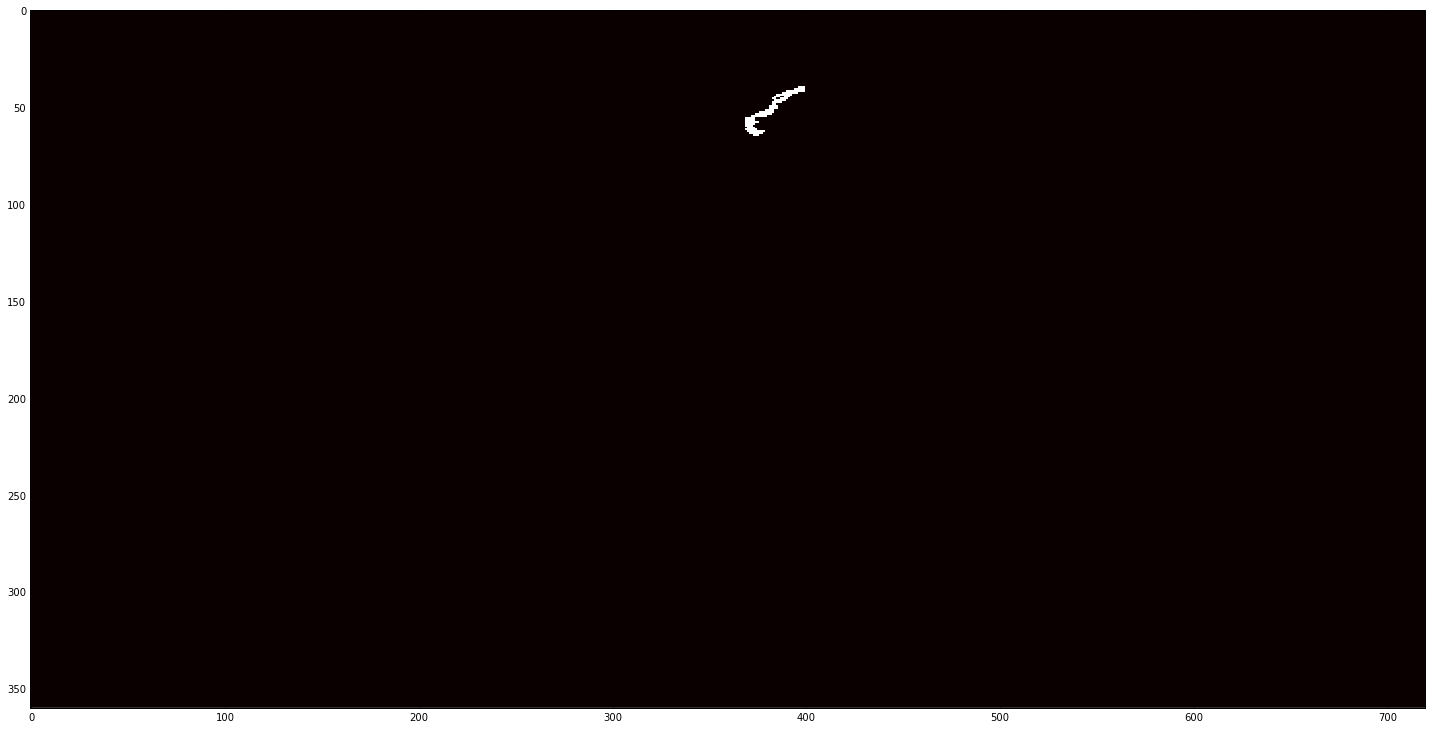

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(25,20))
plt.imshow(freshwater_ecoregions_data_selected, cmap="hot", interpolation="none")

In [37]:
freshwater_ecoregions_data.shape

(21600, 43200)

In [217]:
unique_freshwater_ecoregions = np.unique(freshwater_ecoregions_data)[1:] # discard the "0" == nodata

In [424]:
import pickle
bias_grid = pickle.load(open("../data/bias_grid/bias_grid.pkl", "rb"))
bias_grid_log = pickle.load(open("../data/bias_grid/bias_grid_log.pkl", "rb"))
bias_grid_standardized = pickle.load(open("../data/bias_grid/bias_grid_standardized.pkl", "rb"))
bias_grid_minmax_scale = pickle.load(open("../data/bias_grid/bias_grid_minmax_scale.pkl", "rb"))

In [240]:
bias_grid.shape

(2160, 4320)

In [254]:
bias_grid[np.where(freshwater_ecoregions_data==101)] # number of cells in ecoregion

88

In [268]:
len(np.where(bias_grid[np.where(freshwater_ecoregions_data==101)]>0)[0]) # number of positive cells in biasGrid

32

In [271]:
num_cells_ecoregion_array = []
num_positive_cells_bias_grid_array = []
ratio_array = []
for ecoregion in unique_freshwater_ecoregions:
    number_cells_ecoregion = len(np.where(freshwater_ecoregions_data==ecoregion)[0])
    number_positive_cells_bias_grid = len(np.where(bias_grid[np.where(freshwater_ecoregions_data==ecoregion)]>0)[0])
    ratio = number_positive_cells_bias_grid/number_cells_ecoregion
    num_cells_ecoregion_array.append(number_cells_ecoregion)
    num_positive_cells_bias_grid_array.append(number_positive_cells_bias_grid)
    ratio_array.append(ratio)
#     print("Processed %s, num_cells_ecoregion=%s, number_positive_bias=%s, ratio=%s " % (ecoregion, number_cells_ecoregion, number_positive_cells_bias_grid, ratio))


Processed 101, num_cells_ecoregion=28772, number_positive_bias=32, ratio=0.0011121924092868066 
Processed 102, num_cells_ecoregion=15228, number_positive_bias=7, ratio=0.00045967953769372207 
Processed 103, num_cells_ecoregion=21111, number_positive_bias=347, ratio=0.016436928615413765 
Processed 104, num_cells_ecoregion=13196, number_positive_bias=16, ratio=0.0012124886329190664 
Processed 105, num_cells_ecoregion=28304, number_positive_bias=5, ratio=0.00017665347654041832 
Processed 106, num_cells_ecoregion=18108, number_positive_bias=0, ratio=0.0 
Processed 107, num_cells_ecoregion=4022, number_positive_bias=2, ratio=0.0004972650422675286 
Processed 108, num_cells_ecoregion=6138, number_positive_bias=0, ratio=0.0 
Processed 109, num_cells_ecoregion=11636, number_positive_bias=113, ratio=0.009711240976280509 
Processed 110, num_cells_ecoregion=19331, number_positive_bias=1, ratio=5.173038125290983e-05 
Processed 111, num_cells_ecoregion=25556, number_positive_bias=0, ratio=0.0 
Proce

In [280]:
ratio_array_np = np.array(ratio_array)

In [281]:
ratio_array_np.max()

0.67004396864844196

In [282]:
ratio_array_np.min()

0.0

In [283]:
ratio_array_np.std()

0.065084924732055391

In [284]:
np.where(ratio_array_np==ratio_array_np.max())

(array([149]),)

In [285]:
num_positive_cells_bias_grid_array[149]

3505

In [286]:
num_cells_ecoregion_array[149]

5231

In [291]:
unique_freshwater_ecoregions[149]

405

In [305]:
ecoregions_vs_biasgrid = pd.DataFrame(columns=['ecoregion', 'num_cells_ecoregion', 'num_positive_bias_grid','ratio'])
ecoregions_vs_biasgrid['ecoregion'] = np.array(unique_freshwater_ecoregions)
ecoregions_vs_biasgrid['num_cells_ecoregion'] = np.array(num_cells_ecoregion_array)
ecoregions_vs_biasgrid['num_positive_bias_grid'] = np.array(num_positive_cells_bias_grid_array)
ecoregions_vs_biasgrid['ratio'] = np.array(ratio_array)

In [306]:
ecoregions_vs_biasgrid

,ecoregion,num_cells_ecoregion,num_positive_bias_grid,ratio
0,101,28772,32,0.001112
1,102,15228,7,0.000460
2,103,21111,347,0.016437
3,104,13196,16,0.001212
4,105,28304,5,0.000177
5,106,18108,0,0.000000
6,107,4022,2,0.000497
7,108,6138,0,0.000000
8,109,11636,113,0.009711
9,110,19331,1,0.000052


In [429]:
ecoregions_vs_biasgrid['ratio'].std()

0.06515752366676357

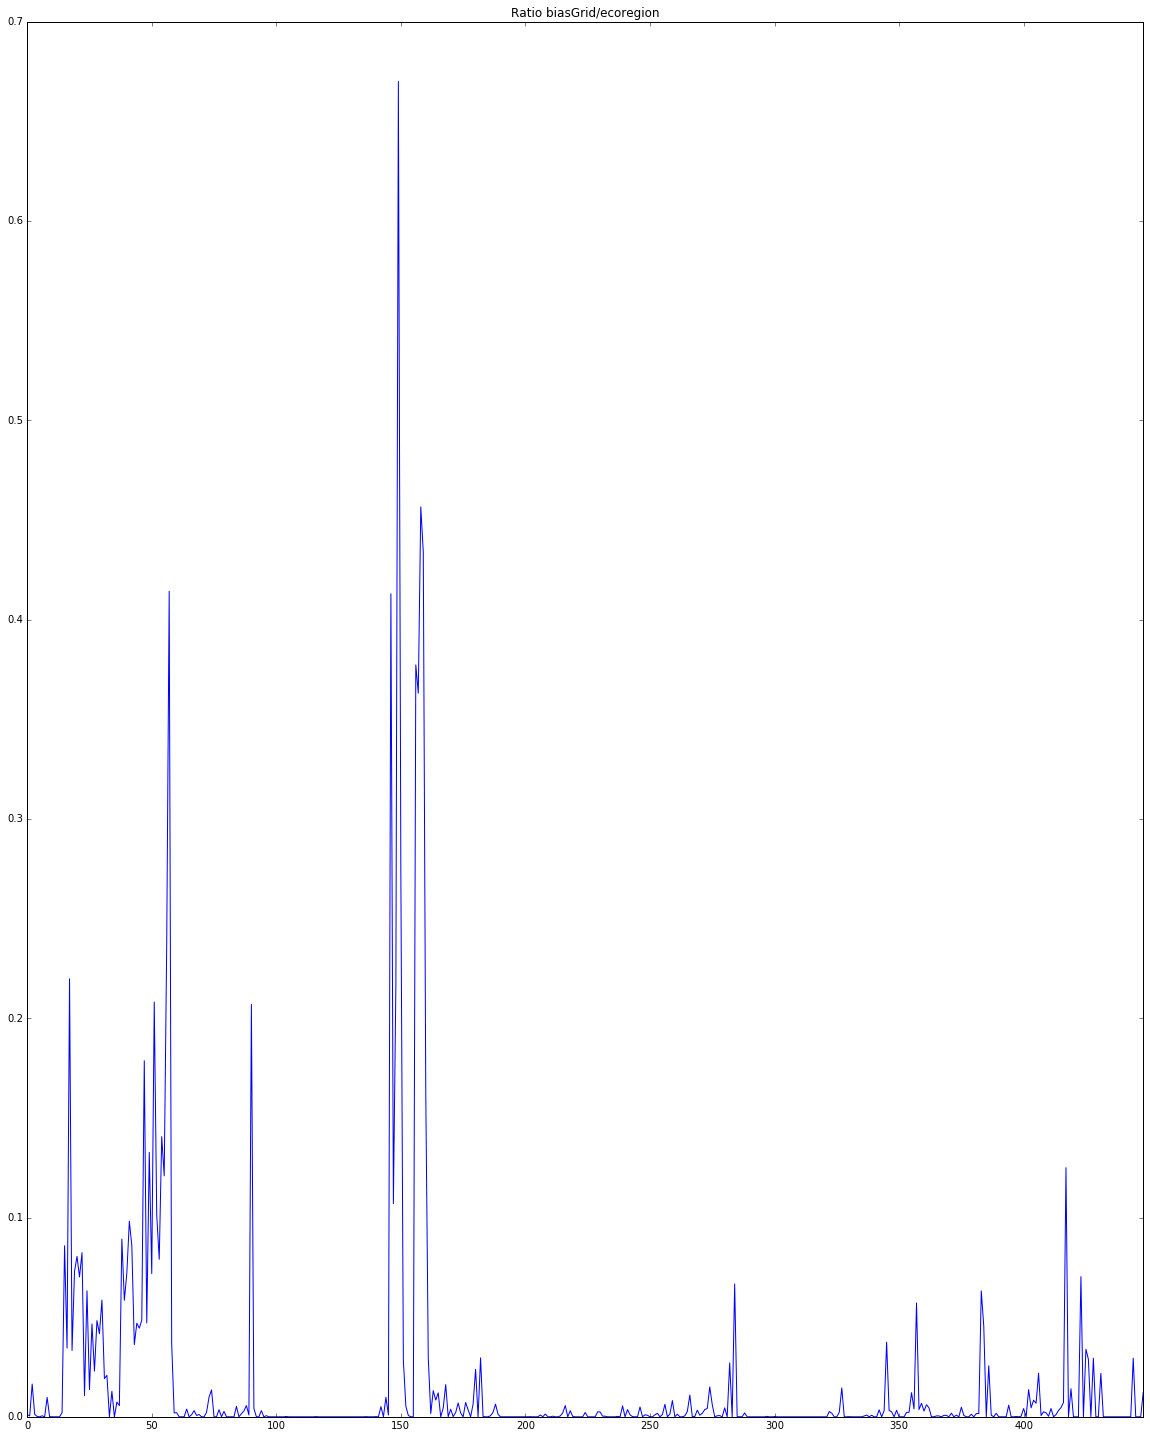

In [345]:
ecoregions_vs_biasgrid['ratio'].plot(figsize=(20,25), title="Ratio biasGrid/ecoregion")

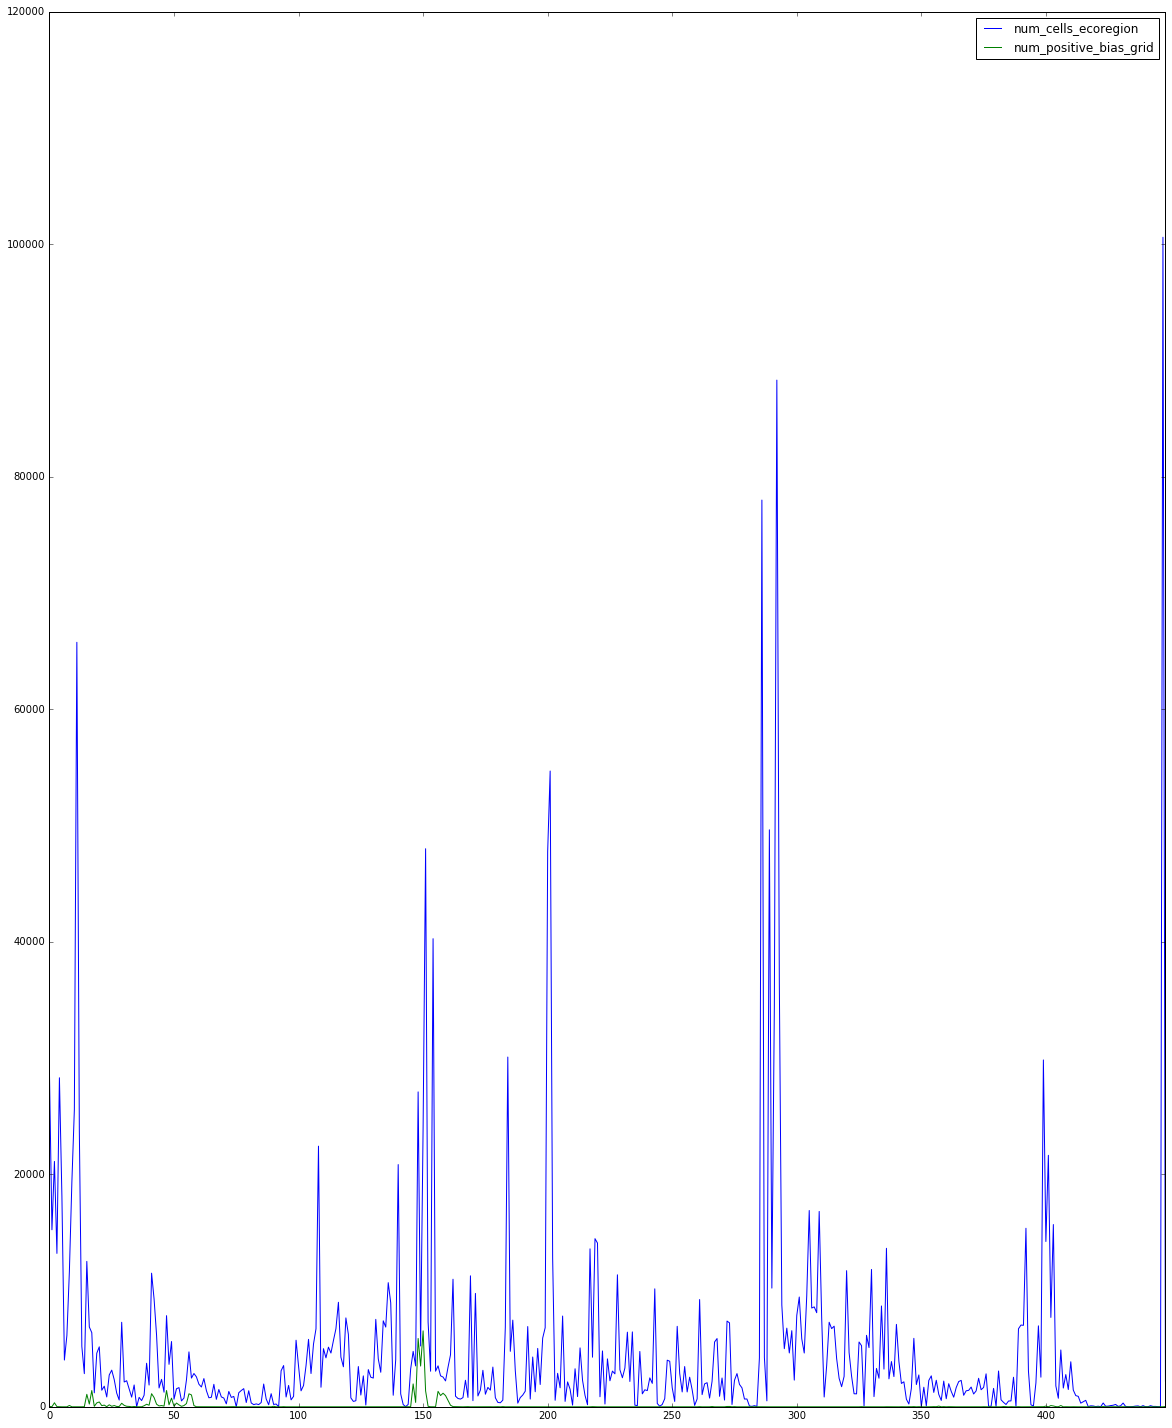

In [327]:
ecoregions_vs_biasgrid[['num_cells_ecoregion','num_positive_bias_grid']].plot(figsize=(20,25))

### Bias grid log

In [344]:
bias_grid_log.shape

(2160, 4320)

In [414]:
def calculate_ratio(some_grid):
    num_cells_ecoregion_array = np.empty(len(unique_freshwater_ecoregions))
    num_positive_cells_bias_grid_array = np.empty(len(unique_freshwater_ecoregions))
    ratio_array = np.empty(len(unique_freshwater_ecoregions))
    for idx, ecoregion in enumerate(unique_freshwater_ecoregions):
        number_cells_ecoregion = len(np.where(freshwater_ecoregions_data==ecoregion)[0])
        number_positive_cells_bias_grid = len(np.where(some_grid[np.where(freshwater_ecoregions_data==ecoregion)]>0)[0])
        ratio = number_positive_cells_bias_grid/number_cells_ecoregion
        num_cells_ecoregion_array[idx] = number_cells_ecoregion
        num_positive_cells_bias_grid_array[idx] = number_positive_cells_bias_grid
        ratio_array[idx] = ratio
    return_df = pd.DataFrame(columns=['ecoregion', 'num_cells_ecoregion', 'num_positive_bias_grid','ratio'])
    return_df['ecoregion'] = np.array(unique_freshwater_ecoregions)
    return_df['num_cells_ecoregion'] = num_cells_ecoregion_array
    return_df['num_positive_bias_grid'] = num_positive_cells_bias_grid_array
    return_df['ratio'] = ratio_array
    return return_df

In [416]:
bias_grid_log_df = calculate_ratio(bias_grid_log)

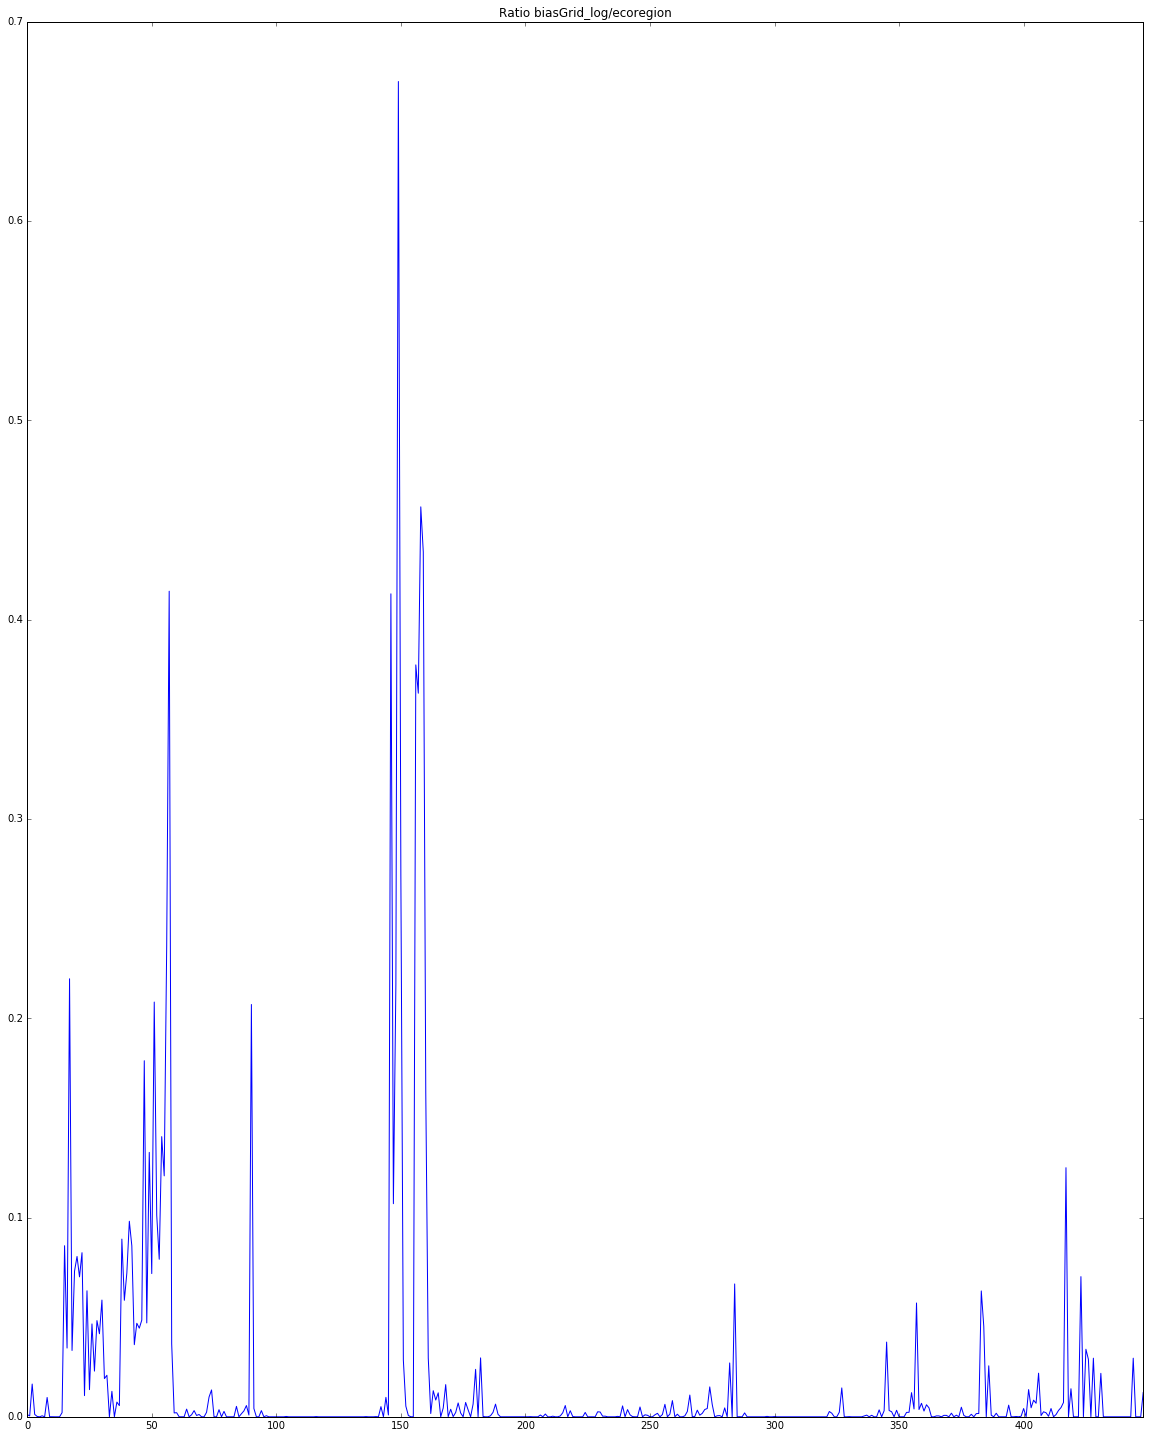

In [419]:
bias_grid_log_df['ratio'].plot(figsize=(20,25), title="Ratio biasGrid_log/ecoregion")

In [420]:
bias_grid_standardized_df = calculate_ratio(bias_grid_standardized)

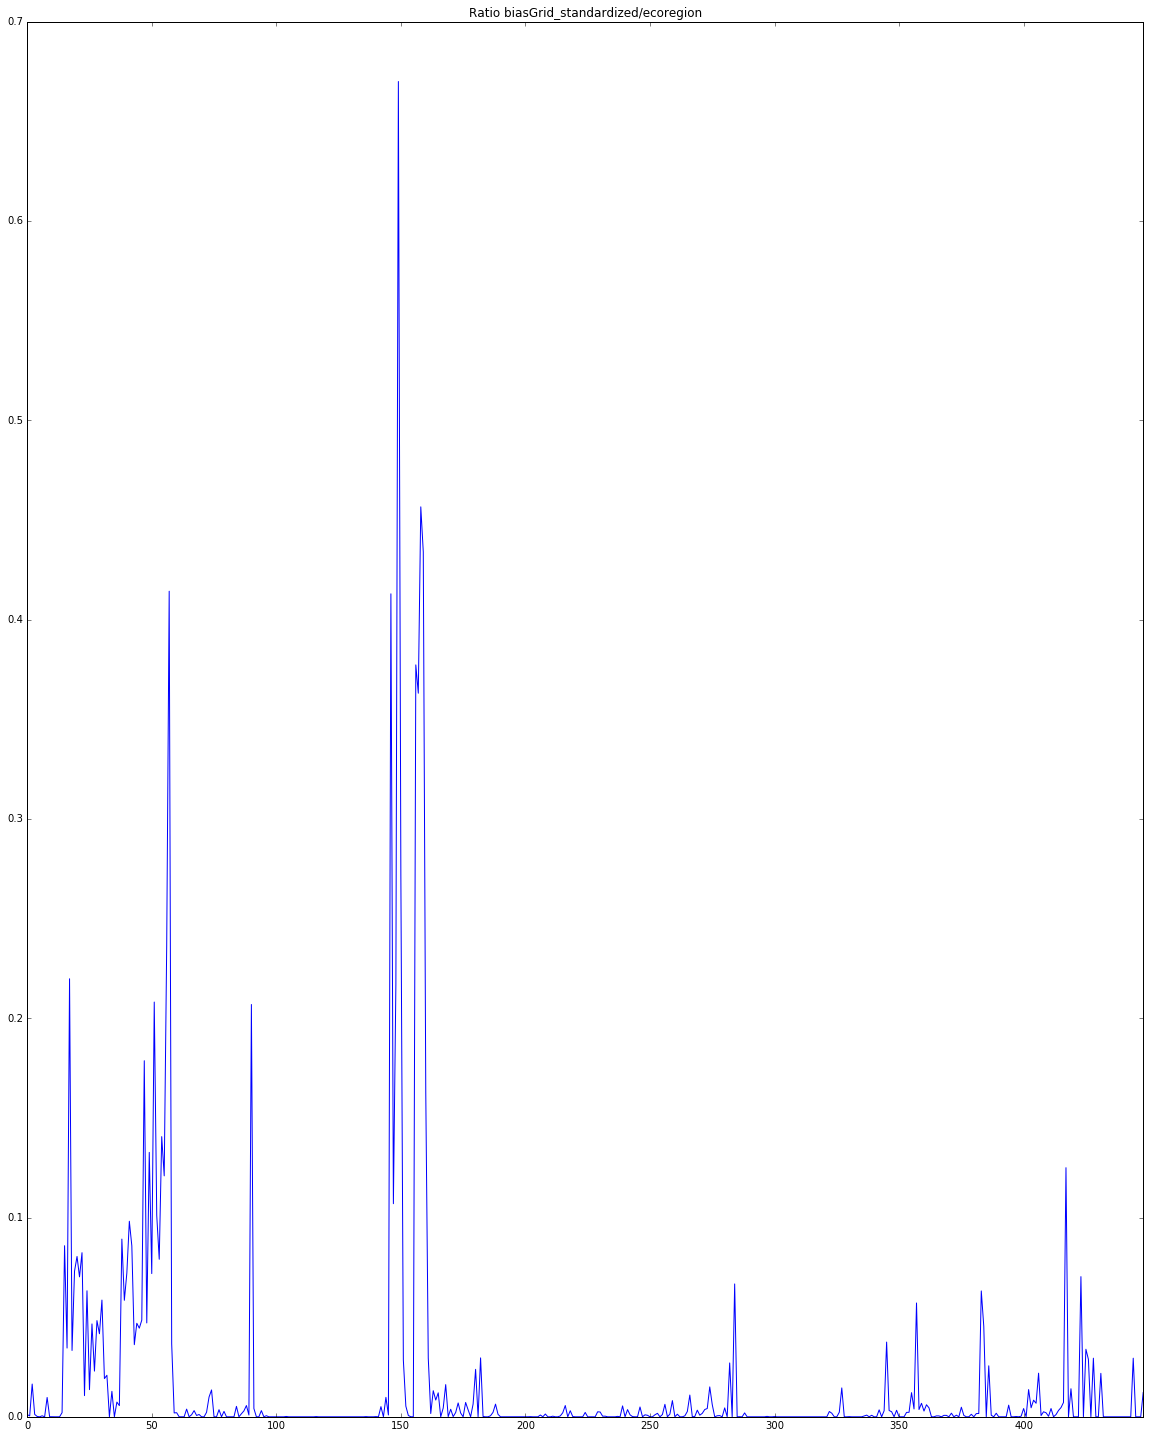

In [423]:
bias_grid_standardized_df['ratio'].plot(figsize=(20,25), title="Ratio biasGrid_standardized/ecoregion")

In [422]:
bias_grid_standardized_df.head()

,ecoregion,num_cells_ecoregion,num_positive_bias_grid,ratio
0,101,28772.0,32.0,0.001112
1,102,15228.0,7.0,0.000460
2,103,21111.0,347.0,0.016437
3,104,13196.0,16.0,0.001212
4,105,28304.0,5.0,0.000177


In [425]:
bias_grid_minmax_scale

1.0

In [426]:
bias_grid_minmax_scale_df = calculate_ratio(bias_grid_minmax_scale)

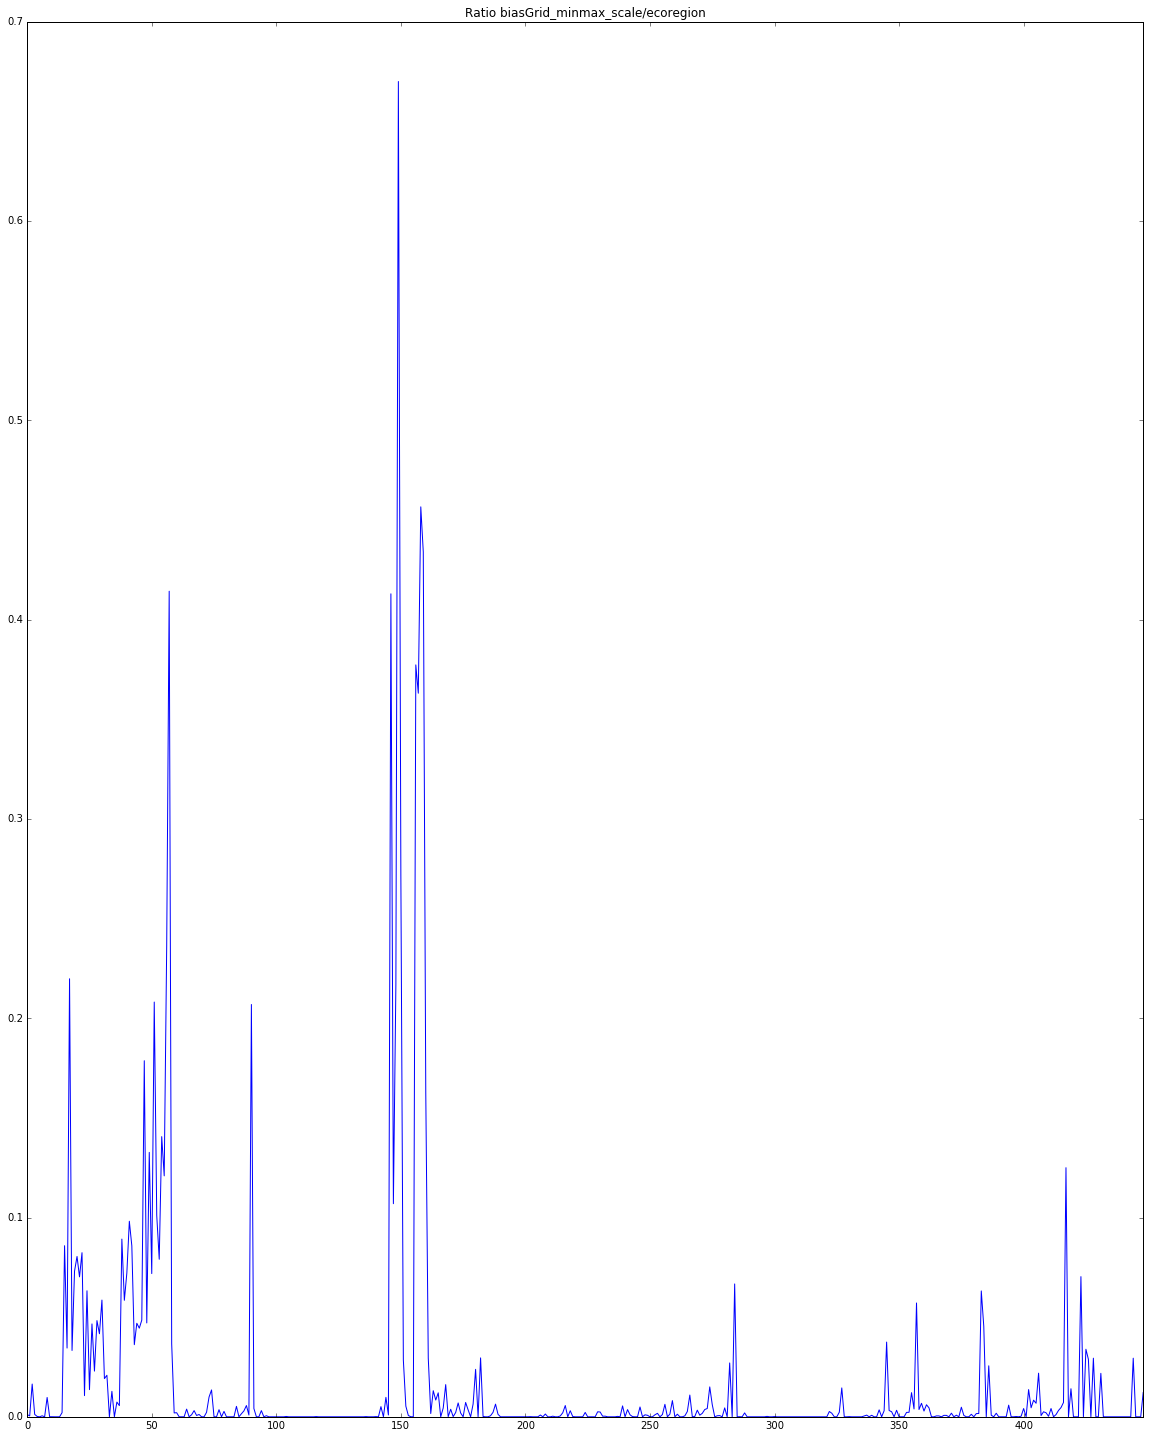

In [427]:
bias_grid_standardized_df['ratio'].plot(figsize=(20,25), title="Ratio biasGrid_minmax_scale/ecoregion")

In [428]:
bias_grid_standardized_df.head()

,ecoregion,num_cells_ecoregion,num_positive_bias_grid,ratio
0,101,28772.0,32.0,0.001112
1,102,15228.0,7.0,0.000460
2,103,21111.0,347.0,0.016437
3,104,13196.0,16.0,0.001212
4,105,28304.0,5.0,0.000177


In [430]:
import gc
gc.collect()

3925